<a href="https://colab.research.google.com/github/EunSik312/623_chungnam/blob/main/7%EC%9B%94_10%EC%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# 1.필요한 라이브러리 임포트
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from google.colab.patches import cv2_imshow
import os


# 2. yt-dlp 설치
!pip install --upgrade yt-dlp

# 2. 간단한 다운로드로 시작
!yt-dlp -f bestvideo https://www.youtube.com/watch?v=tEtWnGwwCEc



[youtube] Extracting URL: https://www.youtube.com/watch?v=tEtWnGwwCEc
[youtube] tEtWnGwwCEc: Downloading webpage
[youtube] tEtWnGwwCEc: Downloading tv client config
[youtube] tEtWnGwwCEc: Downloading tv player API JSON
[youtube] tEtWnGwwCEc: Downloading ios player API JSON
[youtube] tEtWnGwwCEc: Downloading m3u8 information
[info] tEtWnGwwCEc: Downloading 1 format(s): 313
[download] Destination: 강남대로 강남역 도로 드라이브 최근 밤거리 모습 입니다. [tEtWnGwwCEc].webm
[download] 100% of  239.46MiB in 00:00:22 at 10.69MiB/s


7월 10일 야간 인식

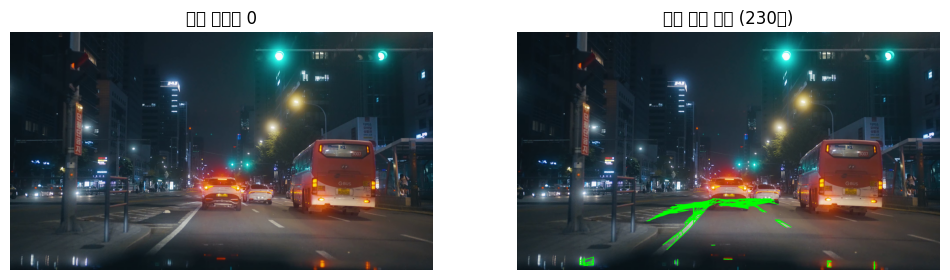


⏹️ 재생 중단


In [22]:
# 4.
import cv2
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time
from google.colab import files

# 영상 업로드
#uploaded = files.upload()
video_path = "/content/강남대로 강남역 도로 드라이브 최근 밤거리 모습 입니다. [tEtWnGwwCEc].webm"

# 영상 열기
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"📹 영상 정보: {frame_count}프레임, {fps:.2f}FPS")
print("🎬 차선 인식 시작! (Ctrl+C로 중단)")

frame_num = 0


# ROI 설정 (도로 영역만 분석) - 좌표는 영상에 맞게 조정 필요
def create_roi_mask(frame):
    height, width = frame.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)
    # 사다리꼴 모양의 도로 영역 설정
    roi_points = np.array([
        [int(width * 0.1), height],                    # 왼쪽 아래
        [int(width * 0.9), height],                    # 오른쪽 아래
        [int(width * 0.6), int(height * 0.7)],         # 오른쪽 위 (70% 지점)
        [int(width * 0.4), int(height * 0.7)]          # 왼쪽 위 (70% 지점)
    ], np.int32)
    cv2.fillPoly(mask, [roi_points], 255)
    return mask

print(f"📹 영상 정보: {frame_count}프레임, {fps:.2f}FPS, {width}x{height}")
print("🎬 차선 인식 시작! (Ctrl+C로 중단)")


fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('lane_detection_result.mp4', fourcc, fps, (width, height))


try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("📺 영상 재생 완료")
            break

        # 1. 그레이스케일 변환
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 2. 블러 → 에지(Canny) - 임계값 낮춤
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 30, 100)  # 50,150 → 30,100

        # 3. ROI 설정 - 하단 30%
        height, width = edges.shape
        mask = np.zeros_like(edges)
        polygon = np.array([[
            (int(width * 0.1), height),            # 왼쪽 아래
            (int(width * 0.9), height),            # 오른쪽 아래
            (int(width * 0.6), int(height * 0.7)), # 오른쪽 위 (70% 지점)
            (int(width * 0.4), int(height * 0.7))  # 왼쪽 위 (70% 지점)
        ]])
        cv2.fillPoly(mask, polygon, 255)
        roi = cv2.bitwise_and(edges, mask)

        # 4. Hough Transform으로 직선 검출 - 파라미터 완화
        lines = cv2.HoughLinesP(roi, 2, np.pi / 180,
                               threshold=30,      # 50 → 30
                               minLineLength=30,  # 40 → 30
                               maxLineGap=80)     # 50 → 80

        # 5. 원본 프레임에 선 그리기
        line_image = frame.copy()
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

        # 6. 결과 출력
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"원본 프레임 {frame_num}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
        plt.title(f"차선 인식 결과 ({len(lines) if lines is not None else 0}개)")
        plt.axis('off')
        plt.show()

        frame_num += 1
        time.sleep(10)  # 10초마다 이걸 바꿔본다.

        # 처리된 MP4 파일 다운로드

except KeyboardInterrupt:
    print("\n⏹️ 재생 중단")



cap.release()
out.release()
#files.download('lane_detection_result.mp4')


ROI
  # 에지 검출 (전체)
            plt.subplot(2, 4, 3)
            plt.imshow(edges, cmap='gray')
            plt.title("total edge detection")
            plt.axis('off')
            # ROI 마스크
            plt.subplot(2, 4, 4)
            plt.imshow(mask, cmap='gray')
            plt.title("ROI mask")
            plt.axis('off')
            # ROI 적용된 에지
            plt.subplot(2, 4, 5)
            plt.imshow(roi, cmap='gray')
            plt.title("ROI after edge")
            plt.axis('off')

In [23]:
import cv2
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

# 영상 업로드
#uploaded = files.upload()
video_path = "/content/강남대로 강남역 도로 드라이브 최근 밤거리 모습 입니다. [tEtWnGwwCEc].mp4"

# 영상 열기
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# ROI 설정 (도로 영역만 분석) - 좌표는 영상에 맞게 조정 필요
def create_roi_mask(frame):
    height, width = frame.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)
    # 사다리꼴 모양의 도로 영역 설정
    roi_points = np.array([
        [int(width * 0.1), height],                    # 왼쪽 아래
        [int(width * 0.9), height],                    # 오른쪽 아래
        [int(width * 0.6), int(height * 0.7)],         # 오른쪽 위 (70% 지점)
        [int(width * 0.4), int(height * 0.7)]          # 왼쪽 위 (70% 지점)
    ], np.int32)
    cv2.fillPoly(mask, [roi_points], 255)
    return mask

print(f"📹 영상 정보: {frame_count}프레임, {fps:.2f}FPS, {width}x{height}")
print("🎬 차선 인식 시작! (Ctrl+C로 중단)")

# 결과 영상 저장 설정
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/content/lane_detection_result.mp4', fourcc, fps, (width, height))

frame_num = 0
display_interval = int(fps * 10)  # 10초마다 (fps * 10 프레임마다)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("📺 영상 재생 완료")
            break

        # 1. 그레이스케일 변환
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 2. 블러 → 에지(Canny) - 임계값 낮춤
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 30, 100)  # 50,150 → 30,100

        # 3. ROI 설정 - 도로 영역만 분석
        mask = create_roi_mask(edges)
        roi = cv2.bitwise_and(edges, mask)

        # 4. Hough Transform으로 직선 검출 - 파라미터 완화
        lines = cv2.HoughLinesP(roi, 2, np.pi / 180,
                               threshold=30,      # 50 → 30
                               minLineLength=30,  # 40 → 30
                               maxLineGap=80)     # 50 → 80

        # 5. 원본 프레임에 선 그리기
        line_image = frame.copy()

        # ROI 영역을 화면에 표시 (사다리꼴 테두리)
        roi_points = np.array([
            [int(width * 0.1), height],                    # 왼쪽 아래
            [int(width * 0.9), height],                    # 오른쪽 아래
            [int(width * 0.6), int(height * 0.7)],         # 오른쪽 위 (70% 지점)
            [int(width * 0.4), int(height * 0.7)]          # 왼쪽 위 (70% 지점)
        ], np.int32)
        cv2.polylines(line_image, [roi_points], isClosed=True, color=(255, 0, 0), thickness=2)

        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

        # ★ 결과 영상에 프레임 저장 ★
        out.write(line_image)

        # 6. 10초마다 1프레임씩 결과 보여주기
        if frame_num % display_interval == 0:
            # 원본과 결과를 나란히 배치
            combined = np.hstack((frame, line_image))

            clear_output(wait=True)
            plt.figure(figsize=(15, 6))
            plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
            plt.title(f"프레임 {frame_num} - 원본 | 차선 인식 결과 ({len(lines) if lines is not None else 0}개)")
            plt.axis('off')
            plt.show()

        # 진행률 표시 (매 프레임마다)
        print(f"\r📊 진행률: {frame_num+1}/{frame_count} ({(frame_num+1)/frame_count*100:.1f}%)", end='')

        frame_num += 1

except KeyboardInterrupt:
    print("\n⏹️ 재생 중단 - 결과 저장 중...")

# 리소스 정리
cap.release()
out.release()

print("\n✅ 처리 완료!")
print("📹 결과 영상이 저장되었습니다: /content/lane_detection_result.mp4")

# 결과 영상 다운로드
print("📥 결과 영상 다운로드 중...")
files.download('/content/lane_detection_result.mp4')

📹 영상 정보: 0프레임, 0.00FPS, 0x0
🎬 차선 인식 시작! (Ctrl+C로 중단)
📺 영상 재생 완료

✅ 처리 완료!
📹 결과 영상이 저장되었습니다: /content/lane_detection_result.mp4
📥 결과 영상 다운로드 중...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# 4.
import cv2
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time
from google.colab import files

# 영상 업로드
#uploaded = files.upload()
video_path = "/content/강남대로 강남역 도로 드라이브 최근 밤거리 모습 입니다. [tEtWnGwwCEc].webm"


# 영상 열기
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"📹 영상 정보: {frame_count}프레임, {fps:.2f}FPS")
print("🎬 차선 인식 시작! (Ctrl+C로 중단)")

frame_num = 0


# ROI 설정 (도로 영역만 분석) - 좌표는 영상에 맞게 조정 필요
def create_roi_mask(frame):
    height, width = frame.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)
    # 사다리꼴 모양의 도로 영역 설정
    roi_points = np.array([
        [int(width * 0.1), height],                    # 왼쪽 아래
        [int(width * 0.9), height],                    # 오른쪽 아래
        [int(width * 0.6), int(height * 0.7)],         # 오른쪽 위 (70% 지점)
        [int(width * 0.4), int(height * 0.7)]          # 왼쪽 위 (70% 지점)
    ], np.int32)
    cv2.fillPoly(mask, [roi_points], 255)
    return mask

print(f"📹 영상 정보: {frame_count}프레임, {fps:.2f}FPS, {width}x{height}")
print("🎬 차선 인식 시작! (Ctrl+C로 중단)")


fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/content/강남대로 강남역 도로 드라이브 최근 밤거리 모습 입니다. [tEtWnGwwCEc].webm', fourcc, fps, (width, height))


try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("📺 영상 재생 완료")
            break

        # 1. 그레이스케일 변환
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 2. 블러 → 에지(Canny) - 임계값 낮춤
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 30, 100)  # 50,150 → 30,100

        # 3. ROI 설정 - 하단 30%
        height, width = edges.shape
        mask = np.zeros_like(edges)
        polygon = np.array([[
            (int(width * 0.1), height),            # 왼쪽 아래
            (int(width * 0.9), height),            # 오른쪽 아래
            (int(width * 0.6), int(height * 0.7)), # 오른쪽 위 (70% 지점)
            (int(width * 0.4), int(height * 0.7))  # 왼쪽 위 (70% 지점)
        ]])
        cv2.fillPoly(mask, polygon, 255)
        roi = cv2.bitwise_and(edges, mask)


        # 4. Hough Transform으로 직선 검출 - 파라미터 완화
        lines = cv2.HoughLinesP(roi, 2, np.pi / 180,
                               threshold=30,      # 50 → 30
                               minLineLength=30,  # 40 → 30
                               maxLineGap=80)     # 50 → 80

        # 5. 원본 프레임에 선 그리기
        line_image = frame.copy()
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

        # 6. 결과 출력
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"원본 프레임 {frame_num}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
        plt.title(f"차선 인식 결과 ({len(lines) if lines is not None else 0}개)")
        plt.axis('off')
        plt.show()

        frame_num += 1
        time.sleep(10)  # 10초마다 이걸 바꿔본다.

        # 처리된 MP4 파일 다운로드

except KeyboardInterrupt:
    print("\n⏹️ 재생 중단")




cap.release()
out.release()
#files.download('lane_detection_result.mp4')


📹 영상 정보: 0프레임, 0.00FPS
🎬 차선 인식 시작! (Ctrl+C로 중단)
📹 영상 정보: 0프레임, 0.00FPS, 0x0
🎬 차선 인식 시작! (Ctrl+C로 중단)
📺 영상 재생 완료
